In [26]:
%matplotlib widget
import sys
import numpy as np
from numpy import pi

import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../src')
sys.path.append('../data')

from pathlib import Path

datap = Path('../data')
%reload_ext autoreload
%aimport load
%aimport utils
%aimport spectr
%aimport plotting

#from definitions import *
from load import read_rad_prof, read_pol_prof, load_binary,extract_to_binary

from scipy.signal import welch, csd, correlate, coherence
from scipy.signal import correlation_lags # Note: requires a recent version of SciPy

from utils import dt, R, NR, Z, dZ, normalized, find_nearest, fluct_level, annot_poloidal_xaxis, Theta, theta_array_OPA
from utils import plot_pdf, pdf_stat

from spectr import get_tau_corr, Corr_profile, nperseg, plot_spec, dx_pol, X_theta, get_kspec, adjacent_Corr
from spectr import Corr_profile_poloidal

from plotting import set_size

# dropbox path:
dropb = Path('/home/sascha/Dropbox/share/TJ-K/')

plt.style.use('../src/tex.mplstyle')
#plt.style.use('default')

In [ ]:
Dat = load_binary('poloidal')

In [ ]:
iPhi = np.arange(0,64, step=2, dtype=int)
Phi = Dat[iPhi]
iIsat = np.arange(1,64, step=2, dtype=int)
Isat = Dat[iIsat]

In [ ]:
bin_centers, Hist, Skew, Kurtosis = pdf_stat(Dat, shot='poloidal', itor=0)

In [ ]:
%autoreload 1
fs = set_size(width='article',fraction=1, aspect_r=1)
fig, ax = plt.subplots(figsize=fs)

plot_pdf(bin_centers, Hist, Skew, Kurtosis, shot='poloidal')
plt.tight_layout()

In [14]:
%autoreload 1
dn, dphi = fluct_level(Dat, itor=0)

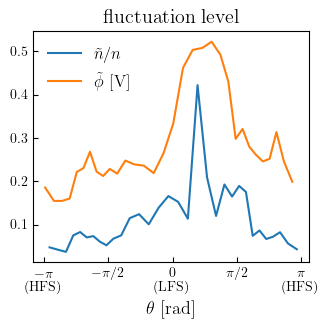

In [23]:
fs = set_size(width='article',fraction=1, aspect_r=1)
fig, ax = plt.subplots(figsize=fs)

ax.plot(theta_array_OPA[iIsat], dn, label=r'$\tilde{n} / n$')
ax.plot(theta_array_OPA[iPhi], dphi, label=r'$\tilde{\phi}$ [V]')

#ax.set_xticks([0, np.pi/2, pi, 3*pi/2, 2*pi])
#ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']);
annot_poloidal_xaxis(ax)
ax.legend()
ax.set_title('fluctuation level')
plt.tight_layout()

#fig.savefig(dropb / 'figures/fluct_pol_OPA.svg')

In [11]:
CrossCorr_phi = adjacent_Corr(Dat, quantity='phi')
CrossCorr_I   = adjacent_Corr(Dat, quantity='I')

In [12]:
CrossCorr_I_E = adjacent_Corr(Dat, quantity='E_I')

In [ ]:
CrossCorr_phi_I = adjacent_Corr(Dat, quantity='phi_I')

In [ ]:
CrossCorr_phi = adjacent_Corr(Dat, quantity='phi', itor=1)
CrossCorr_I   = adjacent_Corr(Dat, quantity='I', itor=1)

NameError: name 'CrossCorr_phi' is not defined

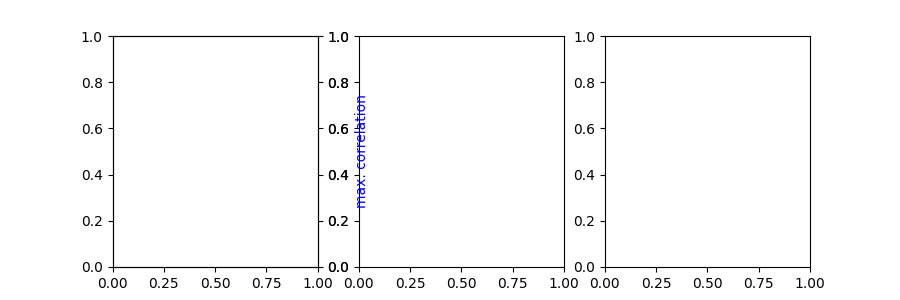

In [65]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(9,3))
_ax1 = ax1.twinx()
_ax1.set_ylabel('max. correlation')
_ax1.yaxis.label.set_color('blue')

ax1.yaxis.label.set_color('red')

for CCorr, ls, lab in zip([CrossCorr_phi, CrossCorr_I], ['-', '--'], [r'$\tilde{\phi}$', r'$\tilde{I}$']):

    tau_c = (CCorr[:,1] - CCorr[:,0] ) / 2

    ax1.plot(Theta[iPhi],  tau_c * 1e6, ls=ls, color='red', label=lab)
    #ax1.set_xlabel('poloidal pos. [mm]')
    ax1.set_ylabel(r'correlation time $\tau_c$ [µs]')
    ax1.set_title(r'$\tau_c$ between adjacent signals')
    
    
    _ax1.plot(X_theta[iPhi] * 1e3, CCorr[:,-1], color='blue', ls=ls)

    tau_max = CCorr[:,2]
    max_corr = CCorr[:,3]
    vfluct = 2 * dx_pol / tau_max
    ax2.plot(Theta[iPhi], vfluct * 1e-3, ls=ls)
    ax2.set_title(r'velocity from correl. delay $C_{\tilde{\phi}_1 \tilde{\phi}_2}$')
    ax2.set_ylabel(r'$v_\theta$ [km/s]')
    #ax2.set_xlabel('poloidal pos. [mm]')
ax1.legend()

CCorr = CrossCorr_phi_I
max_corr = CCorr[:,3]
tau_c = (CCorr[:,1] - CCorr[:,0] ) / 2
ax3.plot(Theta[iPhi],  tau_c * 1e6, color='red', label=lab)
_ax3 = ax3.twinx()
_ax3.plot(Theta[iPhi],  max_corr, ls=ls, color='blue', label=lab)
ax3.set_title(r'CCorrelation $\tilde{\phi} \tilde{I}$')
_ax3.set_ylabel('max. correlation')
_ax3.yaxis.label.set_color('blue')
ax3.set_ylabel(r'correlation time $\tau_c$ [µs]')
ax3.yaxis.label.set_color('red')

for ax in [ax1,ax2,ax3]:
    annot_poloidal_xaxis(ax)

plt.tight_layout()

In [50]:
ACorr_phi = Corr_profile_poloidal(Dat,'phi', itor=0)
ACorr_Isat= Corr_profile_poloidal(Dat, 'I', itor=0)

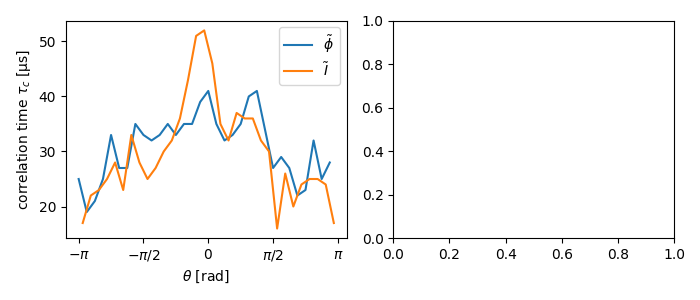

In [52]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

[ax1, ax2] = axs
ith = [iPhi, iIsat]
labels = [r'$\tilde{\phi}$', r'$\tilde{I}$']

for i, ACorr in enumerate([ACorr_phi, ACorr_Isat]):
    
    tau_c = np.mean(np.abs( ACorr[:,:2] ), axis=1)
    ax1.plot(Theta[ith[i]] ,  tau_c * 1e6, label=labels[i])
    ax1.set_xlabel('r-a [mm]')
    ax1.set_ylabel(r'correlation time $\tau_c$ [µs]')
    #ax1.set_title(r'Correlation time')
annot_poloidal_xaxis(ax1)
plt.tight_layout()
ax1.legend()

### Correlate current and electric field

### Fourier analysis, $k_\theta$-space

In [78]:
Phi.shape

(32, 2, 1024000)

In [30]:
kth, kSpec_phi = get_kspec(Dat, quantity='phi', itor=0)
kth, kSpec_Isat = get_kspec(Dat, quantity='I', itor=0)

-0.00582052363307503
-0.00582052363307503


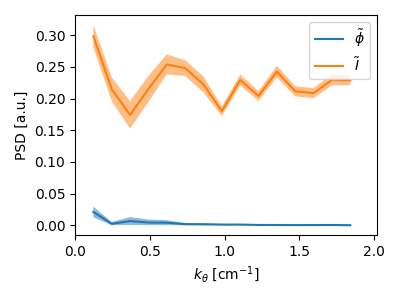

In [32]:
fig, ax = plt.subplots(figsize=(4,3))

labels = [r'$\tilde{\phi}$', r'$\tilde{I}$']

for Kspec, lab in zip([kSpec_phi, kSpec_Isat], labels):
    
    # select positive ktheta:
    kth_pos = kth[kth > 0]
    
    Stheta = np.abs(Kspec)**2
    Stheta = Stheta / Stheta.max()
    Stheta_m = np.mean(Stheta, axis=0)[kth > 0]
    Stheta_std = np.std(Stheta, axis=0)[kth > 0]
    
    ax.plot(kth_pos * 1e-2, Stheta_m, label=lab)

    i_corrlen,_= find_nearest(Stheta_m, Stheta_m.max() / np.exp(1))
    corrlen = 1 / kth[i_corrlen]
    print(corrlen)
    ax.axvline(kth[i_corrlen] * 1e-2)

    y1 = Stheta_m-Stheta_std
    y2 = Stheta_m+Stheta_std
    y1[y1<=0] = Stheta_m.min()
    ax.fill_between(kth_pos * 1e-2, y1=y1, y2=y2, alpha=0.5)
ax.set_xlim(left=0)
ax.set_xlabel(r'$k_\theta$ [cm$^{-1}$]')
ax.set_ylabel('PSD [a.u.]')
#ax.set_yscale('log')
ax.legend()
#ax.set_ylim(bottom=1e-3)
plt.tight_layout()

In [ ]:

"""
fig, ax = plt.subplots()

for itheta in np.arange(start=0, stop = Kspec.shape[-1], step=4):
    frq, spec = welch(Kspec[:,itheta], fs=1/dt, nperseg=nperseg, return_onesided=False)
    frq = fftshift(frq)
    spec = fftshift(spec)

    ax.plot(frq * 1e-3, spec, label='{:.2f}'.format(kth[itheta] * 1e-2))
    
    Doppler_vel = frq[np.argmax(spec)] * 2 * np.pi / kth[itheta]
    print(Doppler_vel)
ax.set_xlim(-50, 50)
ax.legend(ncol=3)
"""